In [1]:
#Downloading dataset
import os
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d raimiazeezbabatunde/candle-image-data
!unzip -q candle-image-data.zip -d ./candlestick_data
print("DONE")

Dataset URL: https://www.kaggle.com/datasets/raimiazeezbabatunde/candle-image-data
License(s): apache-2.0
  0% 0.00/13.4M [00:00<?, ?B/s]
100% 13.4M/13.4M [00:00<00:00, 832MB/s]
DONE


In [2]:
# Importing Libraries
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder


In [3]:
# Resizing data and Data Augmentation
train_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ColorJitter(brightness=0.2),
    transforms.RandomCrop(64, padding=4),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

# Loading dataset
train_dataset = ImageFolder(
    root = '/content/candlestick_data',
    transform=train_transform
)
test_dataset = ImageFolder(
    root = '/content/candlestick_data',
    transform=test_transform
)

# Train-Test split
train_size = int(0.8*len(train_dataset))
test_size = len(train_dataset) - train_size

generator = torch.Generator().manual_seed(11)

train_data, _ = random_split(train_dataset, [train_size, test_size], generator=generator)
_, test_data   = random_split(train_dataset,  [train_size, test_size], generator=generator)


print(f"Training Data: {len(train_data)} images")
print(f"Testing Data: {len(test_data)} images")

Training Data: 1427 images
Testing Data: 357 images


In [4]:
batch_size = 32

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

for X,y in train_dataloader:
  print(f"Shape of X: {X.shape}")  #[batchsize, channels(rbg), height, width]
  print(f"Shape of y: {y.shape}")
  break

Shape of X: torch.Size([32, 3, 64, 64])
Shape of y: torch.Size([32])


In [5]:
import torch
import torch.nn as nn

In [6]:
# Defining CNN model
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    # Feature Extractor
    self.feature_extractor = nn.Sequential(
        # Layer 1
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        # Layer 2
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        # Layer 3
        nn.Conv2d(64, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        # Flattening
        nn.Flatten()
    )
    # Classifier
    self.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(32*8*8, 2)
    )
  def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [7]:
import torch.optim as optim

In [22]:
# Deciding values of Hyperparamters
lr = 0.001
num_epochs = 10

In [23]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
# Training and Evaluation of model
train_losses = []
val_accuracies = []

model = CNN().to(device)
class_weights = torch.tensor([0.83, 0.17]).to(device)
# Choosing loss function and optimizer
criterion = nn.CrossEntropyLoss(weight = class_weights)
optimizer = optim.Adam(model.parameters(), lr)

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  for X,y in train_dataloader:
    X = X.to(device)
    y = y.to(device)
    # Forward pass
    pred = model(X)
    # Evaluate loss
    loss = criterion(pred, y)
    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    running_loss += loss.item()

  avg_loss = running_loss / len(train_dataloader)
  train_losses.append(avg_loss)

  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
    for X,y in test_dataloader:
      X = X.to(device)
      y = y.to(device)
      output = model(X)
      _, pred = torch.max(output.data, 1)
      total += y.size(0)
      correct += (pred == y).sum().item()

  accuracy = 100*correct/total
  val_accuracies.append(accuracy)
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Val Accuracy: {accuracy:.2f}%')

Epoch [1/10], Loss: 0.6911, Val Accuracy: 16.53%
Epoch [2/10], Loss: 0.6932, Val Accuracy: 40.06%
Epoch [3/10], Loss: 0.6893, Val Accuracy: 16.53%
Epoch [4/10], Loss: 0.6842, Val Accuracy: 53.78%
Epoch [5/10], Loss: 0.6898, Val Accuracy: 37.54%
Epoch [6/10], Loss: 0.6836, Val Accuracy: 48.46%
Epoch [7/10], Loss: 0.6778, Val Accuracy: 47.06%
Epoch [8/10], Loss: 0.6803, Val Accuracy: 62.46%
Epoch [9/10], Loss: 0.6777, Val Accuracy: 57.70%
Epoch [10/10], Loss: 0.6718, Val Accuracy: 58.54%


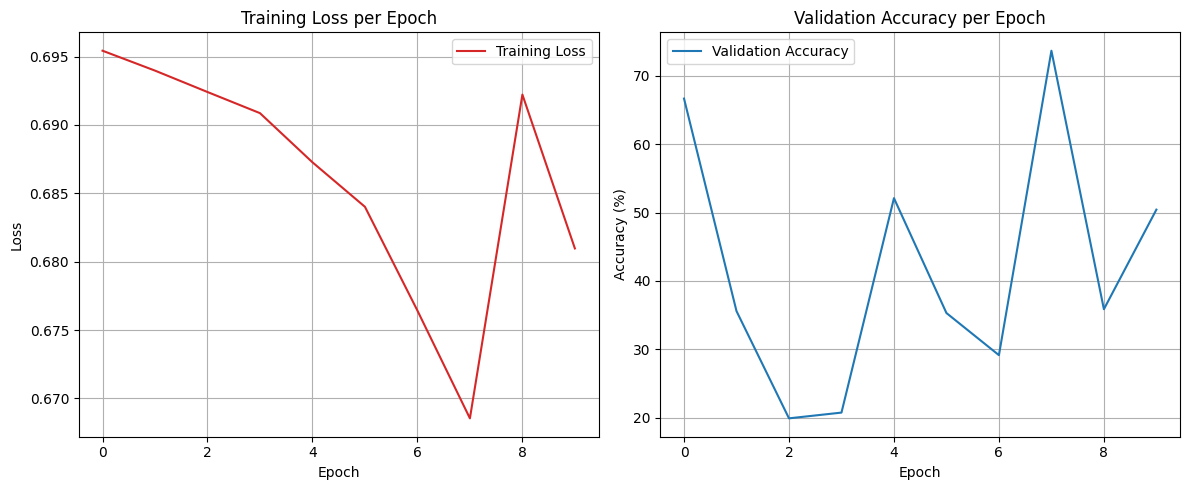

In [17]:
# Plotting results
import matplotlib.pyplot as plt

def plot_results(train_losses, val_accuracies):
    plt.figure(figsize=(12, 5))

    # Plotting Training loss curve
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='tab:red')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    # Plotting accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy', color='tab:blue')
    plt.title('Validation Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_results(train_losses, val_accuracies)

